# Exploratory Discovery Analysis

In this notebook we explore the provided data. First, let set up the environment for the notebook

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# DATA CONFIG
TRAIN_DATA = "data/train.csv"
EXISTING_MRT_DATA = "data/auxiliary-data/auxiliary-data/sg-mrt-existing-stations.csv"

The training data is provided in the `train.csv` file.

In [4]:
train_df = pd.read_csv(TRAIN_DATA)
train_df.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100


# Data Preprocessing
There are several attributes we need to normalize the values.
Let start with `flat_type`

<Axes: ylabel='count'>

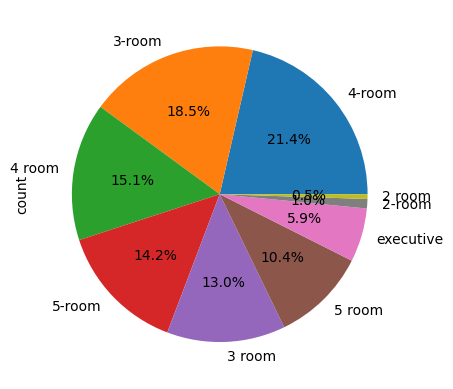

In [5]:
train_df.flat_type.value_counts().plot.pie(autopct="%1.1f%%")

We notice that there is an issue here, 2 room flat can be set as `2 room` or `2-room`. Let clean them up by removing the hyphen.

<Axes: ylabel='count'>

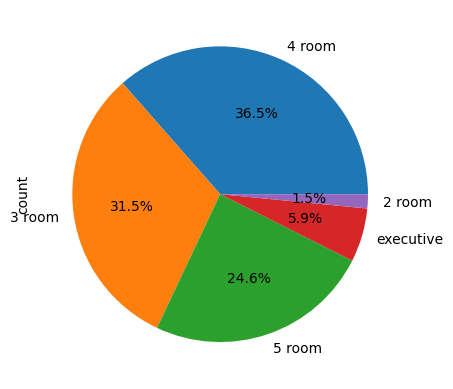

In [6]:
train_df.flat_type = train_df.flat_type.str.replace('-', ' ')
train_df.flat_type.value_counts().plot.pie(autopct="%1.1f%%")

After fixing the values, we can see the most common apartment for rent is 4 room apartments (36.5%), 3 room (31.5%) and 5 room aparments 24.6%)

## Transforming duplicates records

In [21]:
attr_cols = list(train_df.columns.drop('monthly_rent'))
duplicate_indexes = train_df[attr_cols].duplicated()
num_duplicate_records = duplicate_indexes.sum()
print(f"There are {num_duplicate_records} ({num_duplicate_records/len(train_df):.2%}) in the train data")

There are 3457 (5.76%) in the train data


In [22]:
train_df[duplicate_indexes]

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
725,2021-03,ang mo kio,649,ang mo kio avenue 5,3 room,new generation,75.0,yes,1980,1.377763,103.843782,0.0,yio chu kang west,ang mo kio,north-east region,2300
801,2021-01,tampines,157,Tampines Street 12,3 room,new generation,82.0,yes,1985,1.351073,103.945004,0.0,tampines east,tampines,east region,1850
832,2022-11,bishan,407,sin ming avenue,3 room,simplified,64.0,yes,1986,1.363453,103.834215,0.0,upper thomson,bishan,central region,1850
885,2021-02,bukit merah,38,jalan rumah tinggi,4 room,model a,100.0,yes,1997,1.288634,103.809644,0.0,alexandra hill,bukit merah,central region,2950
1184,2023-05,bedok,412,Bedok North Avenue 2,3 room,new generation,67.0,yes,1979,1.329291,103.931091,0.0,bedok north,bedok,east region,2600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59955,2022-03,jurong west,209,boon lay place,3 room,improved,65.0,yes,1976,1.346258,103.715155,0.0,boon lay place,jurong west,west region,2000
59960,2022-02,clementi,611,clementi west street 1,3 room,model a,74.0,yes,1983,1.303697,103.769477,0.0,clementi woods,clementi,west region,2050
59968,2022-07,ang mo kio,433,ang mo kio avenue 10,3 room,new generation,67.0,yes,1979,1.368077,103.854353,0.0,chong boon,ang mo kio,north-east region,1250
59969,2021-08,sengkang,275b,compassvale link,4 room,premium apartment,90.0,yes,2009,1.383339,103.894522,0.0,compassvale,sengkang,north-east region,2950


In [23]:
dedup_traindf = train_df.groupby(attr_cols).mean().reset_index()

In [29]:
# make sure that there is no duplicate records
num_duplicate_left = dedup_traindf.duplicated().sum()
print(f"Number of duplicates record after processing {num_duplicate_left}")

Number of duplicates record after processing 0


## Relationships between facilities and the premise

Using great circle formula, we can calculate the distance (in term of meters) between the premise and other facilities such as MRTs, malls, and primary schools.

First, let see the relationship between distance to MRT and monthly rent. Note that there are several MRT stations having the same location, e.g. NS1/EW24. For those stations, we can safely keep only 1.

In [66]:
from preprocessing import distance_to_nearest_place

MRT_DATAFRAME_PATH = "data/auxiliary-data/auxiliary-data/sg-mrt-existing-stations.csv"
POSITION_ATTRS = ['latitude', 'longitude']
mrt_df = pd.read_csv(MRT_DATAFRAME_PATH).drop_duplicates(POSITION_ATTRS)
dedup_traindf[['nearest_mrt_dist', 'nearest_mrt_code']] = \
    dedup_traindf.apply(
        lambda row: distance_to_nearest_place(row, mrt_df, 'code'),
        axis=1,
        result_type="expand"
)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Before plotting, instead of using `monthly_rent` we can use monthly rent per square meters to normalize the rental.

In [67]:
dedup_traindf['rent_per_sq'] = dedup_traindf['monthly_rent'] / dedup_traindf['floor_area_sqm']
samples = dedup_traindf[dedup_traindf.rent_approval_date == "2021-03"]
samples = samples.sample(500)

<Axes: xlabel='nearest_mrt_dist', ylabel='rent_per_sq'>

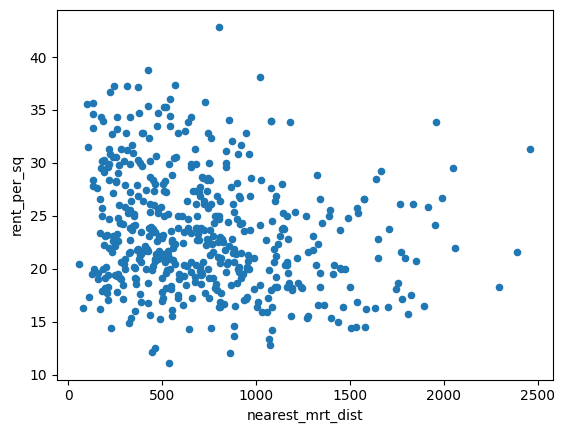

In [68]:
samples.plot.scatter(x='nearest_mrt_dist', y='rent_per_sq')

Most of the premises are 200-600 meters from its closest MRT. There are few apartments that are more than 1000 meters from a MRT. 

<Axes: ylabel='count'>

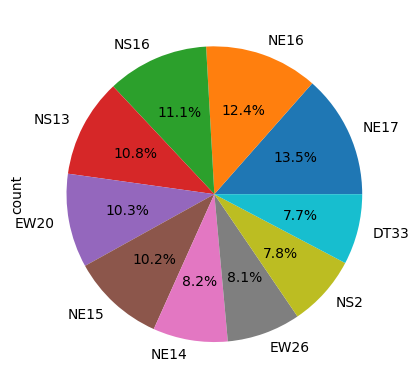

In [54]:
dedup_traindf.nearest_mrt_code.value_counts().nlargest(10).plot.pie(autopct="%1.1f%%")